In [115]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
from ref_trajectory import generate_trajectory as traj
# %matplotlib notebook

There are a lot of configuration parameters. It is a good idea to separate it from the main code. At some point you will be doing parameter tuning. 

We will use toml format to store parameters. Open config.toml and go over the description of the different parameters we may use here

Read the config parameters, default output is a dictionary. You have to then store them as local variables. 
You have 2 options for this
1. update locals() directly - a little bit dangerous
2. You can use itemgetter

In [116]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)
print(dt, V_MAX)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 1, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 0.0}
0.1 1.2


There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable $(v, \omega)$ in that time instant given current $(v, \omega)$$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. Let us integrate these pieces, make sure DWA works for a few paths!

In [117]:
v_min, v_max = 0.0, 0.2
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=11)
ws = np.linspace(w_min, w_max, num=11)
cmd = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
print(vs)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


In [118]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])
    return np.array(poses)

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)
    v_min = max(0, v - ACC_MAX*dt)
    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    epsilon = 1e-6
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])

    # print(commands.shape)
    
    #calculate kappa for the set of commands
    kappa = commands[:,1]/(commands[:,0]+epsilon)
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

def track(ref_path, pose, v, w, dt=0.1):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command, counter = np.inf, None, None
    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose,v,w,N = pred_horizon) #Number of steps = prediction horizon
        # print(local_path.shape)
        
        # if circle_collision_check(grid, local_path): #ignore colliding paths
        #     print("local path has a collision")
        #     continue
        
        #calculate cross-track error
        #can use a simplistic definition of 
        #how close is the last pose in local path from the ref path
        
        ref_dist = list(np.hypot((ref_path[:,0]-local_path[-1,0]),(ref_path[:,1]-local_path[-1,1])))
        ref_idx = ref_dist.index(min(ref_dist))
        cte = ref_dist[ref_idx]
        #other cost functions are possible
        #can modify collision checker to give distance to closest obstacle

        distance = 1
        w_obs = 0
        w_err = 20

        err = np.hypot((ref_path[-1,0]-local_path[-1,0]),(ref_path[-1,1]-local_path[-1,1]))
        cost = w_cte*cte + w_speed*(V_MAX - v)**2 + w_obs/ distance + w_err * err
        
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost, commands[i]
            counter = 1

    if counter :
        return best_command
    else:
        return [0, 0]

In [123]:
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose).T
print(ref_path.shape)
pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:min(len(ref_path)-1,path_index+pred_horizon)]
    print(pose)
    # update path_index using current pose and local_ref_path
    ref_dist = list(np.hypot((ref_path[:,0]-pose[0]),(ref_path[:,1]-pose[1])))
    path_index = ref_dist.index(min(ref_dist))

    # get next command
    v, w = track(local_ref_path,pose,v,w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose,v,w)[0]
    
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")

    if np.hypot((ref_path[-1,0]-pose[0]),(ref_path[-1,1]-pose[1])) < goal_threshold:
        break


(141, 3)
[0.         0.         1.57079633]
idx:0, v:0.050, w:0.000, time:12.1ms
[3.06161700e-19 5.00000000e-03 1.57079633e+00]
idx:0, v:0.100, w:0.000, time:11.4ms
[9.18485099e-19 1.50000000e-02 1.57079633e+00]
idx:0, v:0.150, w:0.000, time:14.7ms
[1.83697020e-18 3.00000000e-02 1.57079633e+00]
idx:0, v:0.200, w:0.000, time:14.9ms
[3.06161700e-18 5.00000000e-02 1.57079633e+00]
idx:0, v:0.250, w:0.000, time:16.4ms
[4.59242550e-18 7.50000000e-02 1.57079633e+00]
idx:0, v:0.300, w:0.000, time:17.1ms
[6.42939570e-18 1.05000000e-01 1.57079633e+00]
idx:0, v:0.350, w:0.000, time:20.0ms
[8.57252759e-18 1.40000000e-01 1.57079633e+00]
idx:1, v:0.400, w:0.000, time:19.1ms
[1.10218212e-17 1.80000000e-01 1.57079633e+00]
idx:1, v:0.450, w:0.000, time:21.2ms
[1.37772765e-17 2.25000000e-01 1.57079633e+00]
idx:1, v:0.500, w:0.000, time:19.5ms
[1.68388935e-17 2.75000000e-01 1.57079633e+00]
idx:1, v:0.550, w:0.000, time:19.6ms
[2.02066722e-17 3.30000000e-01 1.57079633e+00]
idx:1, v:0.600, w:0.000, time:20

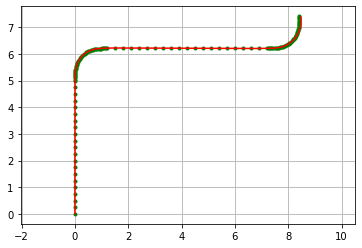

In [124]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
plt.plot(poses[:,0], poses[:,1], c='r')
plt.grid()

Now it should be relatively straight-forward to integrate collision checking in the grid environment the robot is going to navigate